In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2023-04-02 15:25:49.054591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


In [4]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [5]:
'''
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
'''
base_model = keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(64,64,3),
    include_top=False
)

In [6]:
testing_model = keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(32,32,3),
    include_top=False
)
testing_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

testing_model.evaluate(ds_test)

79/79 [==============================] - 2s 15ms/step - loss: 23.9925 - accuracy: 0.0000e+00


[23.99248695373535, 0.0]

In [6]:
'''
#original 
base_model.trainable = False


inputs = keras.Input(shape=(32, 32, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dense(128,activation='relu''relu')
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(10)(x)
model = keras.Model(inputs, outputs)
'''

"\n#original \nbase_model.trainable = False\n\n\ninputs = keras.Input(shape=(32, 32, 3))\n# We make sure that the base_model is running in inference mode here,\n# by passing `training=False`. This is important for fine-tuning, as you will\n# learn in a few paragraphs.\nx = base_model(inputs, training=False)\n# Convert features of shape `base_model.output_shape[1:]` to vectors\nx = keras.layers.GlobalAveragePooling2D()(x)\n#x = keras.layers.Dense(128,activation='relu''relu')\n# A Dense classifier with a single unit (binary classification)\noutputs = keras.layers.Dense(10)(x)\nmodel = keras.Model(inputs, outputs)\n"

In [7]:
#sequential 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.UpSampling2D((2,2)))
#model.add(tf.keras.layers.UpSampling2D((2,2)))
#model.add(tf.keras.layers.UpSampling2D((2,2)))
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(10,activation='softmax'))
  
  


In [8]:
#Traditional Training
#model = tf.keras.models.Sequential([
#  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
#  tf.keras.layers.Dense(128, activation='relu'),
#  tf.keras.layers.Dense(10)
#])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

model.fit(
    ds_train,
    epochs=20,
    batch_size=20,
    validation_data=ds_test,
)


Epoch 1/20


/home/sjhjrok/anaconda3/envs/ai/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 [==============================] - 170s 363ms/step - loss: 0.8578 - accuracy: 0.7140 - val_loss: 3.0410 - val_accuracy: 0.1000
Epoch 2/20
391/391 [==============================] - 149s 374ms/step - loss: 0.6433 - accuracy: 0.7894 - val_loss: 2.6151 - val_accuracy: 0.2915
Epoch 3/20
391/391 [==============================] - 171s 438ms/step - loss: 0.3785 - accuracy: 0.8735 - val_loss: 0.6494 - val_accuracy: 0.7917
Epoch 4/20
391/391 [==============================] - 136s 349ms/step - loss: 0.2942 - accuracy: 0.9003 - val_loss: 0.7085 - val_accuracy: 0.7996
Epoch 5/20
391/391 [==============================] - 145s 364ms/step - loss: 0.4361 - accuracy: 0.8687 - val_loss: 64.6098 - val_accuracy: 0.0924
Epoch 6/20
391/391 [==============================] - 158s 398ms/step - loss: 0.6221 - accuracy: 0.7910 - val_loss: 0.9636 - val_accuracy: 0.6986
Epoch 7/20
391/391 [==============================] - 122s 311ms/step - loss: 0.3762 - accuracy: 0.8768 - val_loss: 0.7076 - val_accur

In [9]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)
testing = model.fit(
    ds_train,
    epochs=10,
    batch_size=20,
    validation_data=ds_test,
)



Epoch 1/10
391/391 [==============================] - 125s 295ms/step - loss: 0.2673 - accuracy: 0.9362 - val_loss: 0.7178 - val_accuracy: 0.8143
Epoch 2/10
391/391 [==============================] - 109s 280ms/step - loss: 0.1791 - accuracy: 0.9518 - val_loss: 0.6613 - val_accuracy: 0.8252
Epoch 3/10
391/391 [==============================] - 112s 287ms/step - loss: 0.1329 - accuracy: 0.9624 - val_loss: 0.6403 - val_accuracy: 0.8339
Epoch 4/10
391/391 [==============================] - 115s 295ms/step - loss: 0.1029 - accuracy: 0.9695 - val_loss: 0.6272 - val_accuracy: 0.8391
Epoch 5/10
391/391 [==============================] - 113s 289ms/step - loss: 0.0824 - accuracy: 0.9756 - val_loss: 0.6233 - val_accuracy: 0.8434
Epoch 6/10
391/391 [==============================] - 112s 286ms/step - loss: 0.0673 - accuracy: 0.9797 - val_loss: 0.6205 - val_accuracy: 0.8458
Epoch 7/10
391/391 [==============================] - 112s 286ms/step - loss: 0.0550 - accuracy: 0.9842 - val_loss: 0.6178 -

<function matplotlib.pyplot.show(close=None, block=None)>

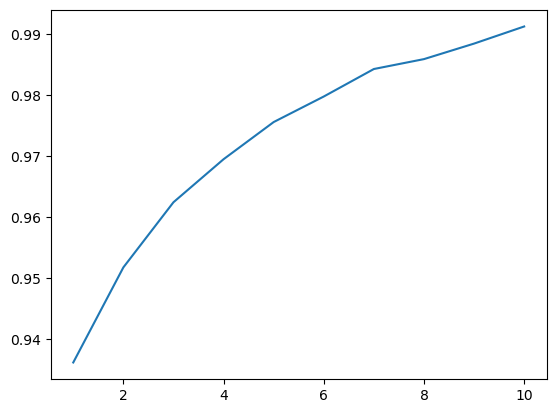

In [10]:

plt.plot(
    np.arange(1, 11), 
    testing.history['accuracy'], label='Accuracy'
)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

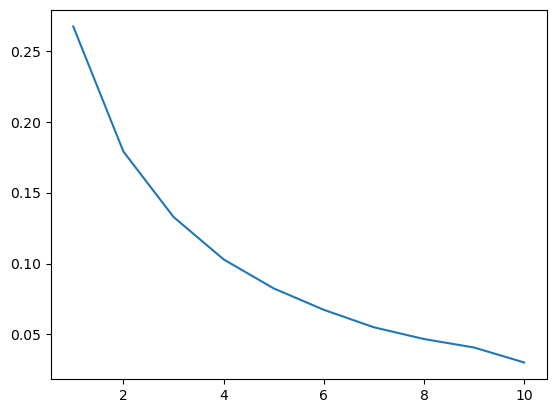

In [11]:
plt.plot(
    np.arange(1, 11), 
    testing.history['loss'], label='Loss'
)
plt.show

In [12]:
model.evaluate(ds_test)


79/79 [==============================] - 3s 32ms/step - loss: 0.6389 - accuracy: 0.8532


[0.6388927698135376, 0.8532000184059143]